# Chocolate Database Analysis

The Open Food Facts (OFF) is a collaborative project where individual can contribute by adding data from the food products they buy.
This project is a practice for visualization and classification specificaly on chocolate products. 

Here is the list of ideas, questions I wanted to investigate:

1. As any chocolate lover knows, there are several types of chocolate bar based on the amount of actual cocoa in the product. My hypothesis is that those categories should have a direct influence on the nutrition values (fat, carbohydrates, protein, etc.). Hence the first idea is to create a model to classify the different types of chocolate bars based on the nutrients.
2. Based on the identified types, see the distribution for the nutrients and the prevalence of certain categories by brands.
3. Map the countries of origin with a visual for the number of product of that origin.
4. Map the dominant type of chocolate for each consumer country.

With no further ado, let's get started!

## Data cleaning and exploration

In [1]:
import pandas as pd #version 2.3.3
import numpy as np #version 2.3.1
import seaborn as sns #version 0.13.2
import matplotlib #version 3.10.0
import matplotlib.pyplot as plt
import statsmodels.api as sm #version 0.14.5

The data was loaded through OFF Python API in order to have an up-to-date dataset with all necessary information for our analysis.  The API provided under MIT Licence. Please see https://github.com/openfoodfacts/openfoodfacts-python.git for further information. The code is detailed in data_loading_from_OpenFoodFacts notebook.  

I took a conservative approach where I kept redundant columns to be sure to capture the required data.

In [2]:
filepath = r'OpenFoodFacts_chocolate.csv'
df = pd.read_csv(filepath)
# removing an index column and redundant columns
df.drop(columns=["Unnamed: 0", "energy_100g", "energy_unit"], inplace=True)
df.head()

,_id,_keywords,generic_name_en,product_name,categories,categories_hierarchy,brands,quantity,ingredients_original_tags,ingredients_text_en,...,salt_100g,salt_unit,saturated-fat_100g,saturated-fat_unit,sodium_100g,sodium_unit,sugars_100g,sugars_unit,energy-kj_100g,energy-kj_unit
0,3046920029759,"['90', 'and', 'bar', 'chocolate', 'cocoa', 'da...",Extra fine dark chocolate 90% cocoa,Supreme Dark 90%,"Snacks,Sweet snacks,Cocoa and its products,Cho...","['en:snacks', 'en:sweet-snacks', 'en:cocoa-and...",Lindt,100 g,"['en:cocoa-paste', 'en:cocoa-butter', 'en:fat-...","cocoa mass, cocoa butter, fat reduced cocoa, s...",...,0.030,g,30.0,g,0.012,g,7.0,g,NaN,NaN
1,6111031005064,"['and', 'beverage', 'bimo', 'biscuit', 'cake',...",NaN,Tonik,"Plant-based foods and beverages,Plant-based fo...","['en:plant-based-foods-and-beverages', 'en:pla...",Bimo,22 g,"['fr:coffret-fourre-au-cacao', 'en:vanilla', '...",NaN,...,0.217,g,10.9,g,0.087,g,40.0,g,2120.0,kJ
2,20995553,"['85', 'and', 'artificial', 'cacao', 'chocolat...",Dark chocolate,Chocolat noir - 85% cacao,"Snacks,Sweet snacks,Cocoa and its products,Cho...","['en:snacks', 'en:sweet-snacks', 'en:cocoa-and...",J.D. Gross,125g,"['en:cocoa-paste', 'en:fat-reduced-cocoa-powde...","Cocoa mass, fat reduced cocoa powder, cocoa bu...",...,0.000,g,28.0,g,0.000,g,12.0,g,NaN,NaN
3,8425197712024,"['almond', 'and', 'ce', 'chocolate', 'cocoa', ...",Compound Chocolate with MILK AND ALMONDS,NaN,"Snacks,Sweet snacks,Cocoa and its products,Con...","['en:snacks', 'en:sweet-snacks', 'en:cocoa-and...",Maruja,150 g,"['en:sugar', 'en:cocoa-butter', 'en:whole-milk...","sugar, cocoa butter, whole milk powder, cocoa ...",...,0.275,g,25.0,g,0.110,g,50.0,g,NaN,NaN
4,3608580065340,"['and', 'bonne', 'breakfast', 'cacao', 'chocol...",NaN,Pâte à tartiner noisettes et cacao,"Breakfasts,Spreads,Sweet spreads,fr:Pâtes à ta...","['en:breakfasts', 'en:spreads', 'en:sweet-spre...",Bonne Maman,360 g,"['en:sugar', 'en:hazelnut', 'en:vegetable-oil'...","sugar, hazelnuts 20%, vegetable oils (sunflowe...",...,0.100,g,5.2,g,0.040,g,51.0,g,2299.0,kJ


In [3]:
df.rename(columns={"fruits-vegetables-nuts-estimate-from-ingredients_100g": "fruits_100g"}, inplace=True)

Here is a description of the dataset:

- id: is the individual entry of the product
- keyords: are generic word for search purpose
- generic_name_en and product_name: are the commercial name either in English or in the original language
- categories, 	categories_hierarchy: standardized name from OOF to group products
- brands: the producer name
- quantity: is the amount sold, here provided as string with the unit aggregated
- countries: comma separated string of countries where the product is sold
- stores: comma separated string of retail brand where the product is sold
- manufacturing_places: it is supposed to countain the manufacturin place but there is a lot of variation in the format, language used. Even sometimes two location indicated. There is some heavy lifting to get usable information out of this column
- origin and origin_en: are supposedly the origin of the product. A quick verification indicates that the columns do not contain the same data. There are relevant info in origin_en regarding the place where the cocoa was grown.
- _100g columns: indicate the amount of the molecule or ingredient per 100 g of product.
- _unit columns: should indicate the unit of the corresponding _100g variable. There is some cleaning to do. For instance "cocoa_unit" contains g, % and % DV units.
- nova-group_100g: indicates the level of processing of the product. Group 1 - Unprocessed or minimally processed foods, Group 2 - Processed culinary ingredients, Group 3 - Processed foods, Group 4 - Ultra-processed food and drink products.
- nutrition-score-fr_100g: indicate the nutritional rating of the product
  

In [4]:
print(df.shape)
# checking if there are any duplicate product in the dataset
df["_id"].duplicated().any()

(15500, 42)


np.False_

First, let's go through the nutrients columns with some cleaning functions.

In [5]:
def standardize_to_gram (df):
    """
    Search for quantities expressed in other scale than gram and convert it to gram.
    The function look out for unit columns ("X_unit), changes the unit of relevant rows to g 
    and then convert the value in the column of the same variable (X_100g) for that row.
    """
    unit_cols = [col for col in df.columns if "_unit" in col]

    for unit_col in unit_cols:
        value_col = unit_col.replace("_unit", "_100g")
        
        # --- Convert Milligrams (mg) to Grams (g) ---
        # Find all rows where the unit is 'mg'
        mg_mask = df[unit_col] == "mg"
        
        # 1a. Convert values: Divide value by 1000
        df.loc[mg_mask, value_col] = df.loc[mg_mask, value_col] / 1000.0
        
        # 1b. Update unit column to 'g'
        df.loc[mg_mask, unit_col] = "g"

        # --- Convert Micrograms (µg) to Grams (g) ---
        # Find all rows where the unit is 'µg'
        ug_mask = df[unit_col] == "µg"
        
        # 2a. Convert values: Divide value by 1,000,000
        df.loc[ug_mask, value_col] = df.loc[ug_mask, value_col] / 1_000_000.0
        
        # 2b. Update unit column to 'g'
        df.loc[ug_mask, unit_col] = "g"

        # extra cleaning, replacing Na value by 0 for the value columns
        # it will facilitate further calculations
        df[value_col] = df[value_col].fillna(0)
        
    return df

def check_100g_complete (df):
    """
    Check if the sum of all main nutrients reaches 100 g. 
    If true, the nutrient data is complete for the product.
    """
    main_nutrients = ["fat_100g", "carbohydrates_100g", "proteins_100g", "fiber_100g", "salt_100g"]
    
    # calculate the total and check for completeness
    total_main_nutrients = df[main_nutrients].sum(axis=1)
    complete_mask = (total_main_nutrients >= 80) & (total_main_nutrients <= 101)

    # filter the column based on completeness
    df_complete = df[complete_mask]
    df_incomplete = df[~complete_mask]
    
    return df_complete, df_incomplete, total_main_nutrients

Why does the filter takes value of completeness between 80 g and 101 g, not exclusively 100 g?
Well for 101 g, I considered that some error could have occured while entering the data and that 1 g of error is not problematic.
While considering the sum of nutrients, there is one big underlying information: the water mass!
The 80 g threshold is based on the fact the lowest water content of a biscuit. I estimated that no chocolate bar would have more water than a biscuit.

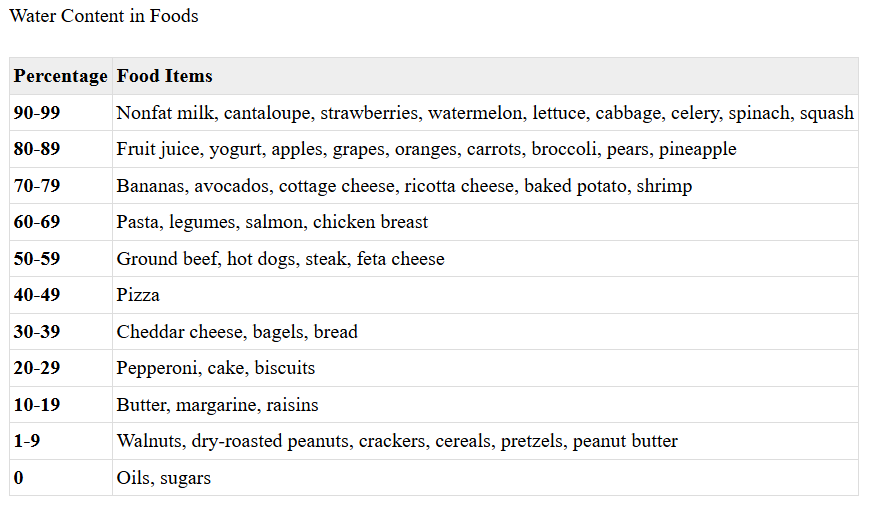

Reuter-Sandquist M; Open Resources for Nursing (Open RN); Ernstmeyer K, Christman E, editors. Nursing Assistant [Internet]. Eau Claire (WI): Chippewa Valley Technical College; 2022. Table 6.2, [Water Content in Foods]. Available from: https://www.ncbi.nlm.nih.gov/books/NBK599380/table/ch6basicnursing.T.water_content_in_foods/
Licensed under a Creative Commons Attribution 4.0 International License.

In [6]:
df = standardize_to_gram(df)
df_complete, df_incomplete, total_main_nutrients = check_100g_complete(df)
df_complete.shape

(12166, 42)

In [7]:
df_complete["origin"].info()

<class 'pandas.core.series.Series'>
Index: 12166 entries, 1 to 15499
Series name: origin
Non-Null Count  Dtype 
--------------  ----- 
172 non-null    object
dtypes: object(1)
memory usage: 190.1+ KB


Only 172 non-null values in the column origin, 65 in origin_en. It makes less than 2 % of the rows with nutrients value.
Retrieving food producer countries form Food and Agriculture Organisation See FAOSTAT_data_en_11-10-2025.csv from https://www.fao.org/faostat/en/#data/QCL. Cleaning some of the name to ease the search within our initial dataset

In [8]:
cocoa_producer_fr = ["Côte d'Ivoire", "Ghana", "Indonésie", "Nigeria", "Cameroun", "Brésil", "Équateur", 
                     "Mexique", "Pérou", "République dominicaine", "Afrique de l'ouest"]

filepath = r'FAOSTAT_data_en_11-10-2025.csv'
df_cocoa_producer = pd.read_csv(filepath)
cocoa_producer_en = df_cocoa_producer["Area"].tolist()

short_name = {"Bolivia (Plurinational State of)":"Bolivia", "Micronesia (Federated States of)": "Micronesia", 
              "Venezuela (Bolivarian Republic of)":"Venezuela", "China, Taiwan Province of":"Taiwan", "Côte d'Ivoire":"Ivory coast"}

for long_name, short_name_alias in short_name.items():
    index_to_change = cocoa_producer_en.index(long_name)
    cocoa_producer_en[index_to_change] = short_name_alias


Cleaning brand names (WORK IN PROGRESS)

import jellyfish
df['Metaphone'] = df['Name_Preprocessed'].apply(lambda x: jellyfish.metaphone(str(x)))

# Assuming your DataFrame 'df' has columns: 'Name_Original', 'Name_Preprocessed', 'Metaphone'
from fuzzywuzzy import fuzz

def create_name_map(block_df, threshold=88):
    """Creates a mapping for a single phonetic block."""
    unique_names = block_df['Name_Preprocessed'].unique()
    
    # 1. Determine the Canonical Name (most frequent in this block)
    canonical_name = block_df['Name_Preprocessed'].mode()[0]
    
    name_map = {}
    
    for name in unique_names:
        if name == canonical_name:
            name_map[name] = canonical_name
            continue
            
        # 2. Compare against the canonical name
        score = fuzz.token_sort_ratio(name, canonical_name)
        
        # 3. Map if score is high enough
        if score >= threshold:
            name_map[name] = canonical_name
        else:
            # If it's similar but not quite enough, leave it as is 
            # (or map to itself, indicating no change)
            name_map[name] = name 
            
    return name_map

# Run for all blocks
final_map = {}
for metaphone_key, block_df in df.groupby('Metaphone'):
    block_map = create_name_map(block_df)
    final_map.update(block_map)

# Apply the final map to the original column
df['Name_Cleaned'] = df['Name_Preprocessed'].map(final_map)

In [9]:
## Data visualization

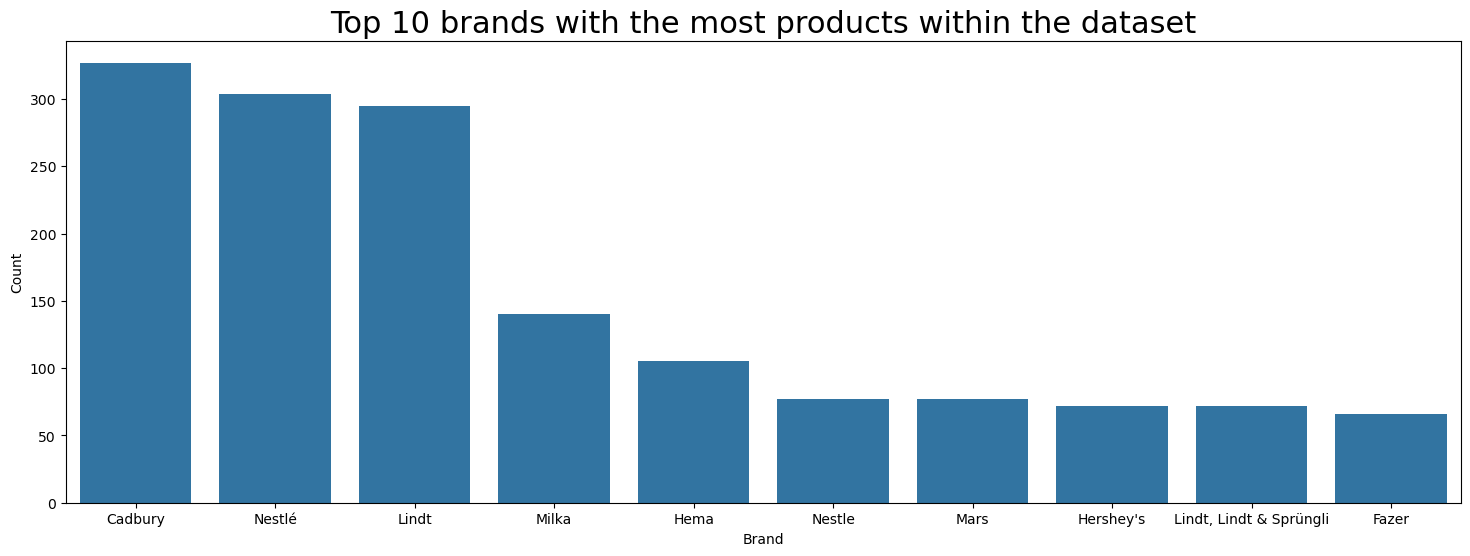

In [10]:
top_10_brands_df = df_complete["brands"].value_counts().head(10).reset_index()
top_10_brands_df.columns = ["Brand", "Count"]

plt.figure(figsize=(18, 6))
sns.barplot(x="Brand", y="Count", data=top_10_brands_df, width=0.8)
plt.title("Top 10 brands with the most products within the dataset", fontsize=22, fontweight=25)
plt.show()

In [11]:
# Selecting only nutrients columns for analytical purpose
nutrients_cols = [col for col in df_complete.columns if "_100g" in col]
nutrients_cols.remove("energy-kcal_100g")
nutrients_cols.remove("nutrition-score-fr_100g")
nutrients_cols.remove("nova-group_100g")

In [12]:
# Selecting only data with the cocoa content so that we have labeled data to train and test our models.
cocoa_mask = df_complete["cocoa_100g"] != 0
df_cocoa = df_complete[cocoa_mask].copy()

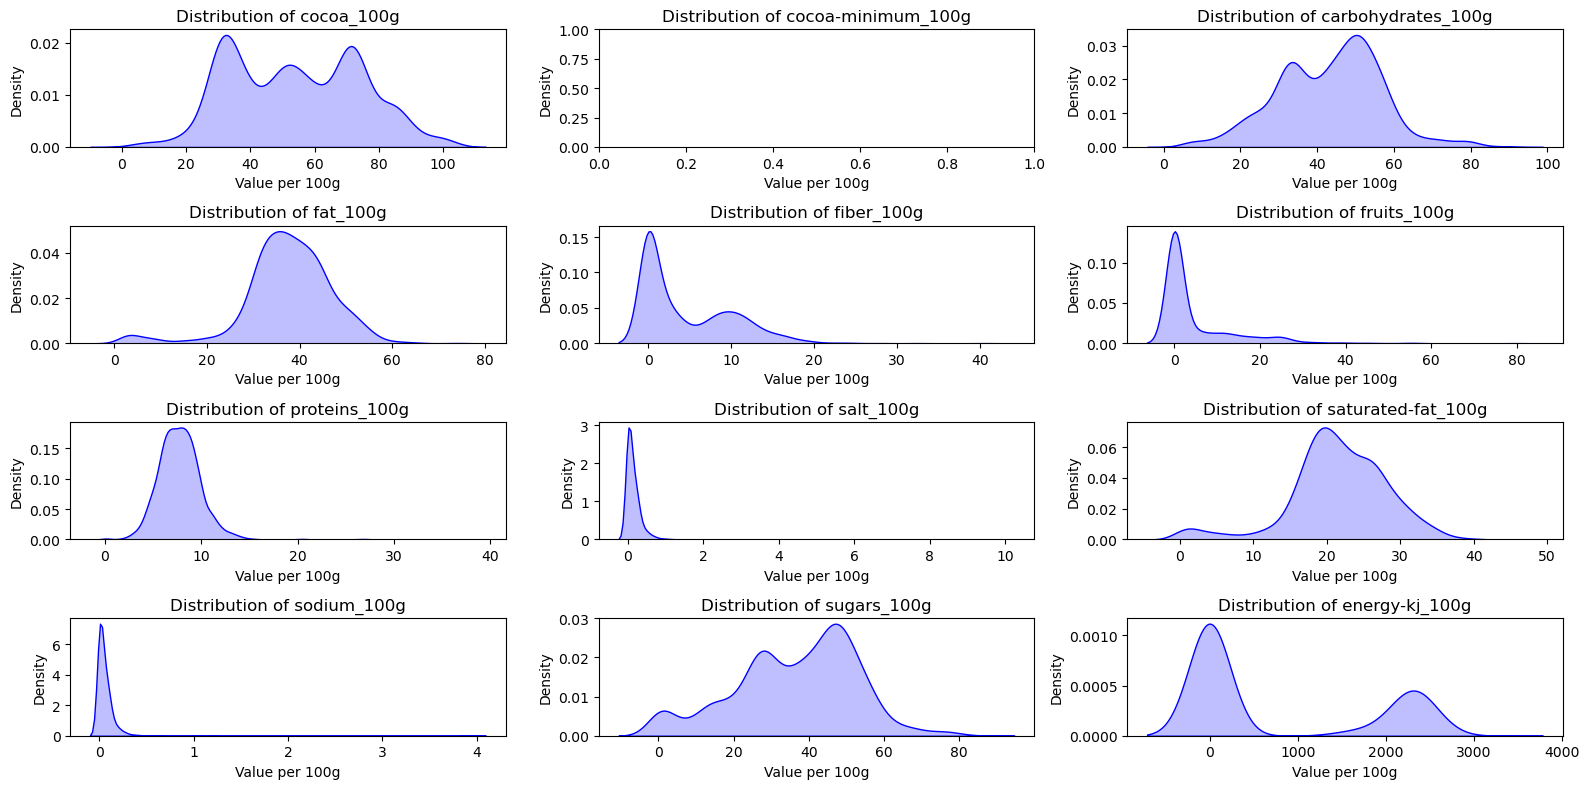

In [13]:
# plotting the distribution of nutrients

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 8))
axes_flat = axes.flatten() # reduce the axes list from 2D to 1D array

for col_name, ax in zip(nutrients_cols, axes_flat):
    sns.kdeplot(df_cocoa[col_name], label=col_name, fill=True, color='blue', ax=ax, warn_singular=False)
    ax.set_title(f'Distribution of {col_name}', fontsize=12)
    ax.set_xlabel('Value per 100g')
    
plt.tight_layout()
plt.show()

<Axes: xlabel='sodium_100g', ylabel='Density'>

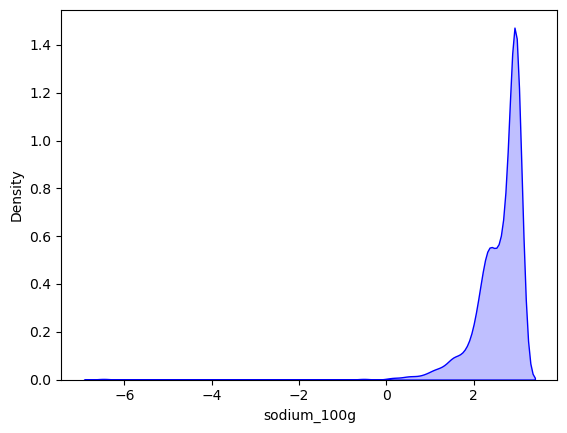

In [14]:
# testing safe log transform
sns.kdeplot(-10*np.log10(df_cocoa["sodium_100g"]+0.5), label=col_name, fill=True, color='blue')

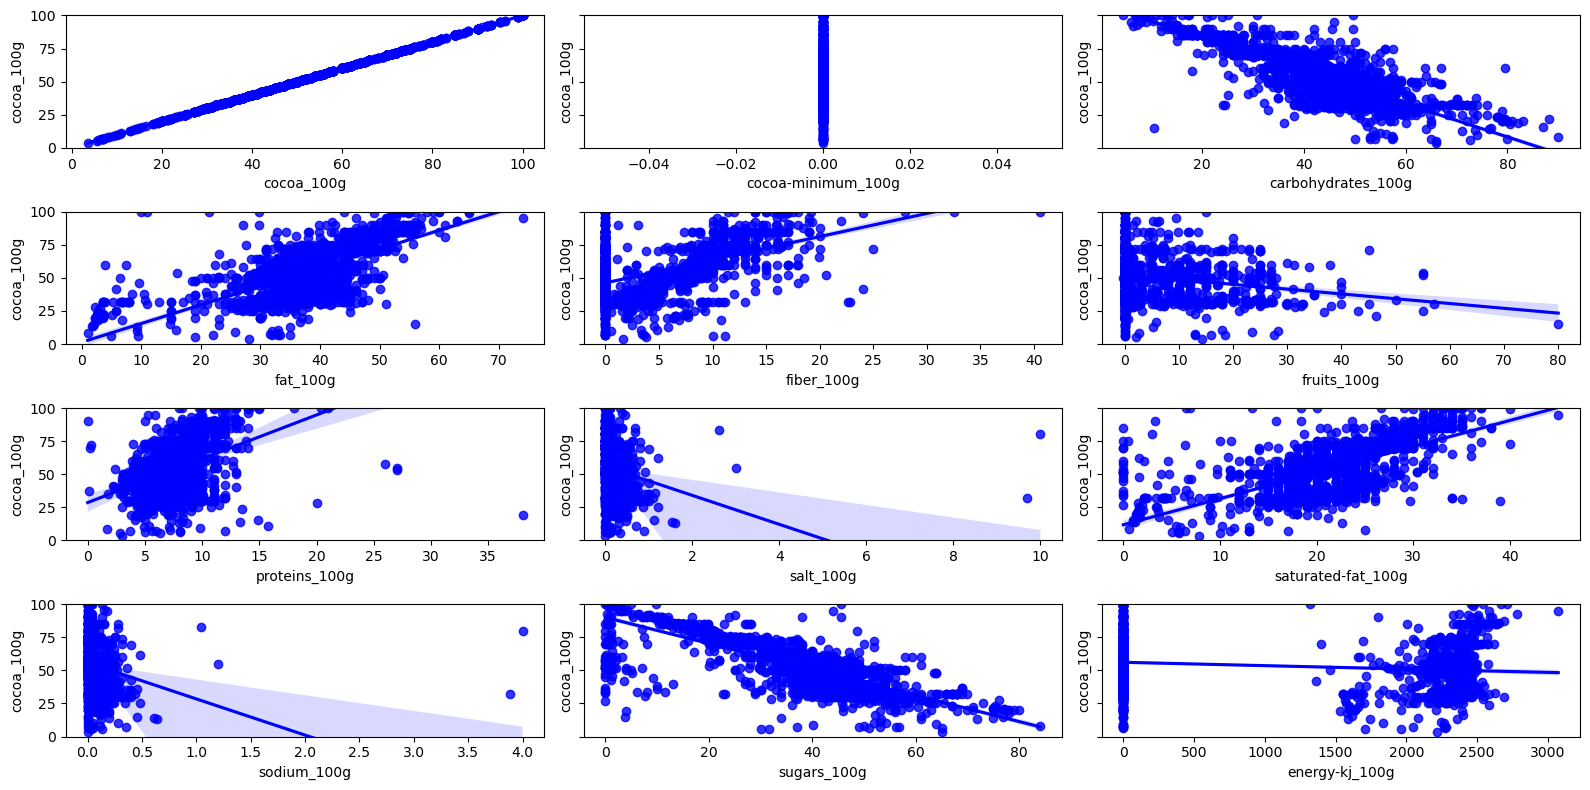

In [15]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 8), sharey=True)

axes_flat = axes.flatten()

for col_name, ax in zip(nutrients_cols, axes_flat):
    sns.regplot(x=df_cocoa[col_name], y=df_cocoa["cocoa_100g"], color='blue', ax=ax)
    plt.xlabel(col_name)
    plt.ylabel("cocoa_100g")
    ax.set_ylim(0, 100)   

plt.tight_layout()
plt.show()

It is quite surprising to see so many product with zero energy value.
Knowing the nutrition composition should allow for the energy content calculation.
The FAO recomends some conversion factors proposed by Paul and Southgate (1978) for energy estimation.
Carbohydrates, proteins and fat gives respectively 16, 17, 37 kJ/g.
https://www.fao.org/4/m2847e/m2847e00.htm

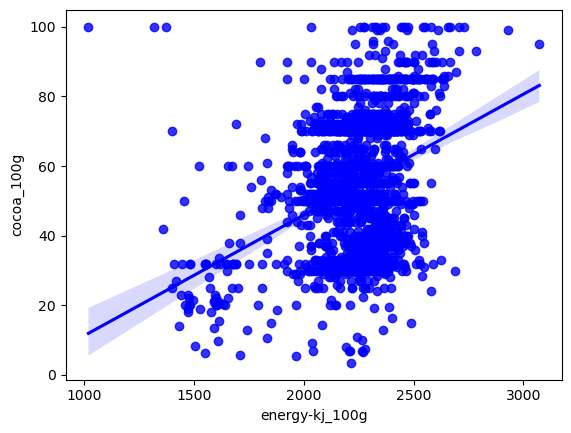

In [16]:
null_energy_mask = df_cocoa["energy-kj_100g"] == 0
df_cocoa.loc[null_energy_mask, "energy-kj_100g"] = (16*df_cocoa.loc[null_energy_mask, "carbohydrates_100g"] \
                                                    + 17*df_cocoa.loc[null_energy_mask, "proteins_100g"] \
                                                    + 37*df_cocoa.loc[null_energy_mask, "fat_100g"])

sns.regplot(x=df_cocoa["energy-kj_100g"], y=df_cocoa["cocoa_100g"], color='blue')
plt.show()

According to the wikipedia chocolate page, 35 % is often recognized as the lower limit to considerate a chocolate as dark.
This article from Abbey Bigler posted on Biomedical Beat Blog of the National Institute of General Medical Sciences gives a classification which also includes the 35 %.
https://nigms.nih.gov/biobeat/2020/02/the-chemistry-of-chocolate

I decided to cut the milk chocolate at 10 % and consider lower content of cocoa as the hallmark of white chocolate.
Also, quite arbitrarily I admit, chocolate above 65 % of cocoa will be categorized as "intense" chocolate.

Those label will be stored in a new column called "chocolate_type".

In [17]:
white_mask = df_cocoa["cocoa_100g"] <= 10
milk_mask = (df_cocoa["cocoa_100g"] > 10) & (df_cocoa["cocoa_100g"] <= 35)
dark_mask = (df_cocoa["cocoa_100g"] > 35) & (df_cocoa["cocoa_100g"] <= 65)
intense_mask = df_cocoa["cocoa_100g"] > 65

df_cocoa.loc[white_mask, "chocolate_type"] = 'White'
df_cocoa.loc[milk_mask, "chocolate_type"] = 'Milk'
df_cocoa.loc[dark_mask, "chocolate_type"] = 'Dark'
df_cocoa.loc[intense_mask, "chocolate_type"] = 'Intense'

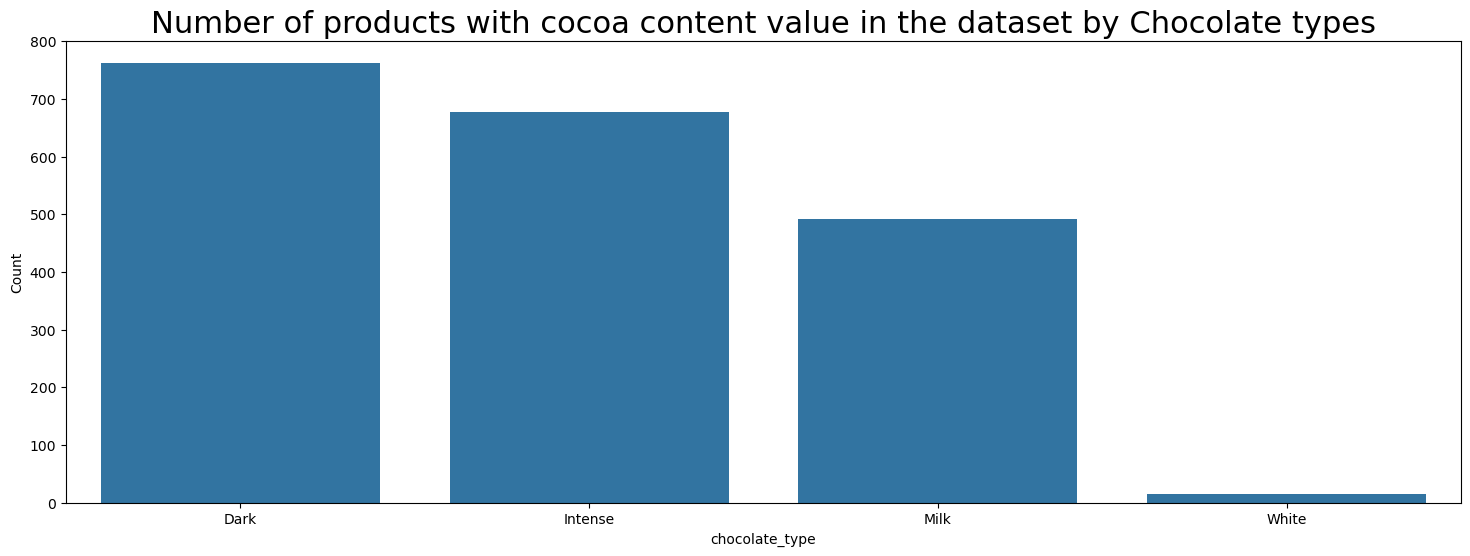

In [18]:
chocolate_types_df = df_cocoa["chocolate_type"].value_counts().reset_index()
chocolate_types_df.columns = ["chocolate_type", "Count"]

plt.figure(figsize=(18, 6))
sns.barplot(x="chocolate_type", y="Count", data=chocolate_types_df, width=0.8)
plt.title("Number of products with cocoa content value in the dataset by Chocolate types", fontsize=22, fontweight=25)
plt.show()

In [19]:
## PCA

In [20]:
pca_cols = nutrients_cols.copy()
pca_cols.remove("cocoa-minimum_100g")
pca_cols.remove("cocoa_100g")
pca_cols.remove("salt_100g")
pca_cols.remove("sodium_100g")
pca_cols.remove("fruits_100g")


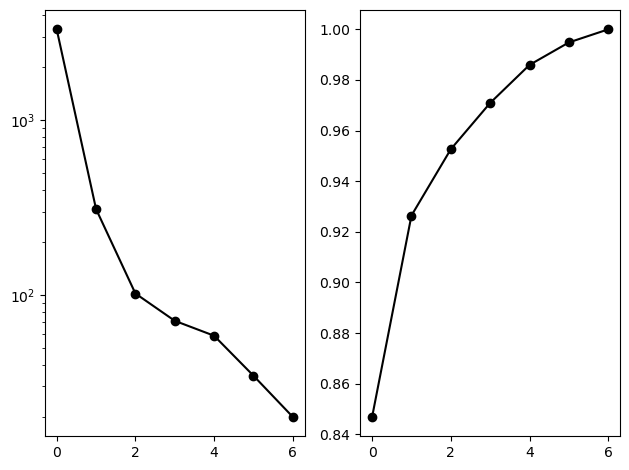

In [21]:
# Because there is no row with cocoa and cocoa minimum, 
# we remove cocoa minimum from the analysis 
X = df_cocoa[pca_cols].to_numpy()
nrows = X.shape[0]
ncols = X.shape[1]

Xavg = np.mean(X,axis=0)                          # Compute mean
B = X - Xavg                                      # Mean-subtracted data
U, S, VT = np.linalg.svd(B/np.sqrt(ncols),full_matrices=0)

fig1 = plt.figure()
ax1 = fig1.add_subplot(121)
ax1.semilogy(S,'-o',color='k')
ax2 = fig1.add_subplot(122)
ax2.plot(np.cumsum(S)/np.sum(S),'-o',color='k')

plt.tight_layout()
plt.show()

In [22]:
def calculate_omega(beta):
    """
    Calculates the correction factor, Omega(beta), required for the
    Gavish-Donoh optimal hard threshold (when noise level is unknown).

    This factor is derived from the Marchenko-Pastur distribution and 
    corrects for the aspect ratio of the data matrix.

    Args:
        beta (float): The aspect ratio of the data matrix (min(M, N) / max(M, N)).
                      Must be between 0 and 1.
    Returns:
        float: The correction factor Omega(beta).
    """
    if not (0 <= beta <= 1):
        raise ValueError("Aspect ratio beta must be between 0 and 1.")

    # The calculation involves complex integrals, but for the optimal
    # threshold, the result is the largest eigenvalue of the Marchenko-Pastur
    # density function, given by the boundary of the distribution:
    # (1 + sqrt(beta))^2
    
    # NOTE: The formula for tau is actually tau = Omega * sigma_median, 
    # where Omega = sqrt(2 * (1 + beta) + (1 + beta) * sqrt(4 * beta / (1 + beta)^2))
    # This simplifies significantly. 
    
    # The value often used in implementations (related to Marchenko-Pastur law):
    return np.sqrt(2 * (1 + beta) + (1 + beta) * np.sqrt(4 * beta / (1 + beta)**2))

def gavish_donoh_threshold(S, M, N):
    """
    Calculates the optimal hard threshold (tau) for Singular Value Decomposition (SVD)
    truncation using the Gavish-Donoh method, assuming the noise level (gamma) is unknown.
    
    This function implements the 'median singular value' approach (Case 2 in the lecture).

    Args:
        S (np.ndarray): The array of singular values (from np.linalg.svd) in descending order.
        M (int): Number of rows (samples or features, depending on matrix orientation).
        N (int): Number of columns (features or samples).
        
    Returns:
        float: The optimal threshold value (tau). All singular values < tau are truncated.
    """
    
    # 1. Calculate the aspect ratio (beta)
    # beta is defined as min(M, N) / max(M, N). We use a small epsilon to avoid division by zero.
    beta = min(M, N) / max(M, N + np.finfo(float).eps)

    # 2. Find the median singular value (Sigma_median)
    # The singular values S are assumed to be sorted in descending order (standard for np.linalg.svd).
    sigma_median = np.median(S)
    
    # 3. Calculate the correction factor Omega(beta)
    # This factor is derived from the Marchenko-Pastur law related to the SVD of random matrices.
    # The actual optimal threshold formula for the median singular value is often approximated 
    # by the Marchenko-Pastur boundary which is sqrt((1+sqrt(beta))^2).
    # A common (and simpler) implementation uses the factor:
    # tau = (sqrt((1+sqrt(beta))^2) + sqrt(1+beta)) * sigma_median 
    
    # However, the most accurate implementation of the hard threshold uses a more precise formula 
    # derived by Gavish and Donoho. We can use the simple, robust Marchenko-Pastur limit as 
    # the factor, which is sufficient for most applications.
    # We will use the explicit formula derived from their work related to the Marchenko-Pastur limit:
    
    # The Marchenko-Pastur upper bound (lambda_max):
    mp_lambda_max = (1 + np.sqrt(beta))**2
    
    # The threshold tau is then typically:
    tau_factor = np.sqrt(mp_lambda_max)
    tau = tau_factor * sigma_median

    return tau

def optimal_svd_rank(S, M, N):
    """
    Calculates the optimal rank (R) to truncate the SVD using the Gavish-Donoh threshold.
    """
    tau = gavish_donoh_threshold(S, M, N)
    
    # The optimal rank R is the count of singular values greater than the threshold tau
    optimal_rank = np.sum(S > tau)
    
    return optimal_rank, tau

In [23]:
r, tau = optimal_svd_rank(S, nrows, ncols)

In [30]:
T = U[:,0:r] @ np.diag(S[0:r])
df_pca = pd.DataFrame(T, columns=['PC1', 'PC2', 'PC3'])
df_pca["category"] = df_cocoa["chocolate_type"].values # taking only values to avoid mismatch of rows


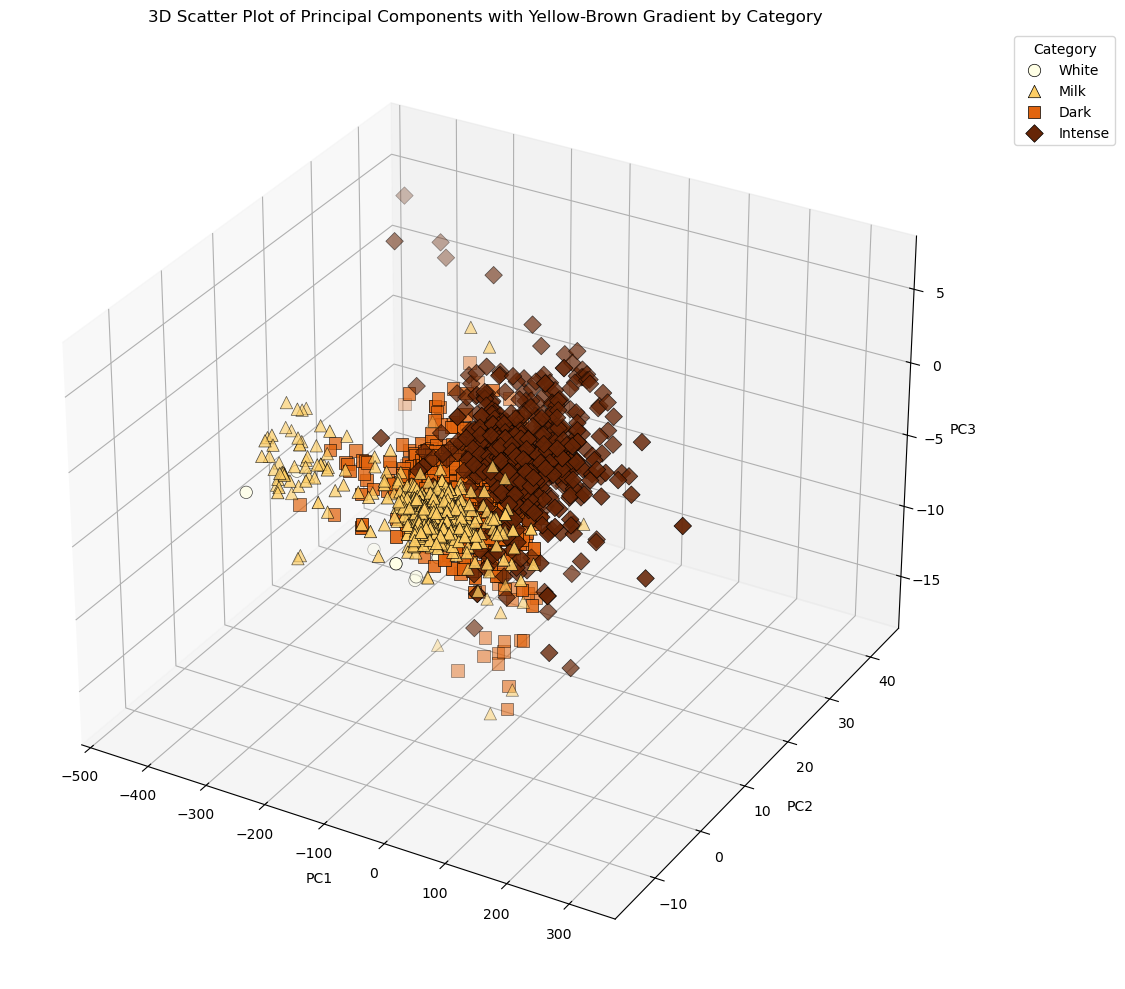

In [31]:
import matplotlib.cm as cm # Import colormap module
from matplotlib.colors import Normalize # For mapping data to colors

cmap = plt.colormaps['YlOrBr']

unique_category = ["White", "Milk", "Dark", "Intense"]
num_category = len(unique_category)

norm = Normalize(vmin=0, vmax=num_category - 1)

markers = ['o', '^', 's', 'D']

category_colors = {
    cat: cmap(norm(i))
    for i, cat in enumerate(unique_category)
}
category_markers = {typ: markers[i % len(markers)] for i, typ in enumerate(unique_category)}

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

for category in unique_category:
    subset = df_pca[df_pca['category'] == category]
    
    color = category_colors[category] 
    marker = category_markers[category]
    
    ax.scatter(
        subset['PC1'],
        subset['PC2'],
        subset['PC3'],
        c=[color],        # 'c' expects a list of colors if plotting multiple points at once
        marker=marker,
        label=category,
        s=80,             # Slightly larger markers for better visibility
        edgecolors='black',
        linewidth=0.5
    )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.set_title('3D Scatter Plot of Principal Components with Yellow-Brown Gradient by Category')

ax.legend(title='Category', loc='upper left', bbox_to_anchor=(1.05, 1))

plt.tight_layout()
plt.show()

Through the dimensionality reduction, the chocolate type seems to indeed be located in different groups. The next dynamic plot allows for a better visualization of those groups.

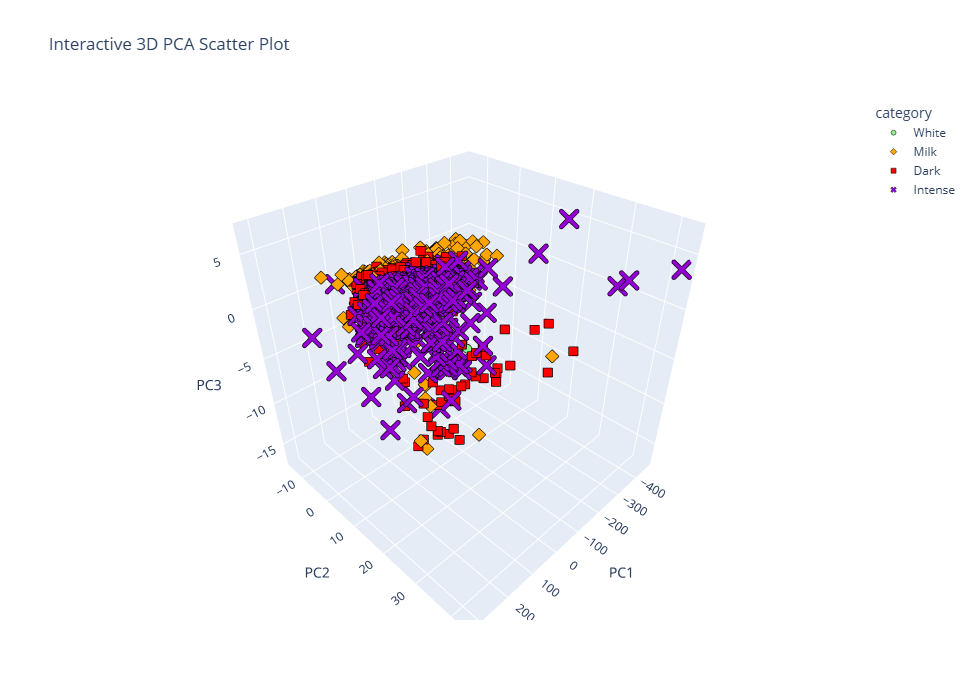

In [38]:
import plotly.express as px

custom_distinct_colors = [
    'LightGreen', # For 'Low'
    'Orange',     # For 'Medium'
    'Red',        # For 'High'
    'DarkViolet'  # For 'Critical'
]

fig = px.scatter_3d(
    df_pca, 
    x='PC1', 
    y='PC2', 
    z='PC3',
    color='category', # Use the 'category' column to assign colors
    symbol='category', # Use the 'category' column to assign shapes (optional, but good for clarity)
    color_discrete_sequence=custom_distinct_colors,
    title='Interactive 3D PCA Scatter Plot',
    height=700,
    category_orders={'category': unique_category}
)

fig.update_traces(marker=dict(size=5, line=dict(width=0.5, color='black')))

fig.show()

Interistingly, using pre-labeled products allows to see Intense, Dark and Milk chocolate types as somewhat distinct groups. They seems also to be organized in a logical continuum with Dark type located between Intense and Milk types. The White type does not seem to be actually different than the Milk type. 

The Dark type is fragmented in two distinct sub-groups. There are also several points that fall further from the apparent groups.
Clusters will be studied with classification methods.

## Classification